In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from scipy.stats import loguniform


In [72]:
df = pd.read_csv("twitter_bots_final.csv")

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37438 entries, 0 to 37437
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   default_profile              37438 non-null  bool   
 1   default_profile_image        37438 non-null  bool   
 2   description                  37438 non-null  object 
 3   favourites_count             37438 non-null  int64  
 4   followers_count              37438 non-null  int64  
 5   friends_count                37438 non-null  int64  
 6   geo_enabled                  37438 non-null  bool   
 7   lang                         37438 non-null  object 
 8   verified                     37438 non-null  bool   
 9   average_tweets_per_day       37438 non-null  float64
 10  account_age_days             37438 non-null  int64  
 11  account_type                 37438 non-null  object 
 12  word_count                   37438 non-null  int64  
 13  mean_word_length

In [74]:
df['account_type'].value_counts(normalize=True)

human    0.668118
bot      0.331882
Name: account_type, dtype: float64

In [75]:
# drop unnecessary columns
df1 = df.drop(columns=['description_en', 'description'])

# define feature groups 
bool_cols = ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']
cat_cols = ['lang', 'description_language']
num_cols = [
    'favourites_count', 'followers_count', 'friends_count',
    'average_tweets_per_day', 'account_age_days', 'word_count',
    'mean_word_length', 'hashtag_count', 'handle_count',
    'url_count', 'log_followers_friends_ratio'
]
target_col = 'account_type'

# convert target to binary
df1[target_col] = df1[target_col].map({'human': 0, 'bot': 1})

# split train/test 80/20
from sklearn.model_selection import train_test_split

train_df1, test_df1 = train_test_split(
    df1,
    test_size=0.2,
    stratify=df1[target_col],
    random_state=42
)

print("Train:", train_df1.shape)
print("Test:", test_df1.shape)

# boolean to int
train_df1[bool_cols] = train_df1[bool_cols].astype(int)
test_df1[bool_cols]  = test_df1[bool_cols].astype(int)

# one-hot encode categorical columns
train_df1 = pd.get_dummies(train_df1, columns=cat_cols, drop_first=True)
test_df1  = pd.get_dummies(test_df1, columns=cat_cols, drop_first=True)
test_df1  = test_df1.reindex(columns=train_df1.columns, fill_value=0)

# scale numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_df1[num_cols] = scaler.fit_transform(train_df1[num_cols])
test_df1[num_cols]  = scaler.transform(test_df1[num_cols])

# convert embeddings into arrays
import numpy as np
def str_to_array(s):
    s = s.strip("[]")
    return np.array(s.split(), dtype=float)

train_df1['description_en_embeddings'] = train_df1['description_en_embeddings'].apply(str_to_array)
test_df1['description_en_embeddings'] = test_df1['description_en_embeddings'].apply(str_to_array)

X_train_embed = np.vstack(train_df1['description_en_embeddings'].values)
X_test_embed  = np.vstack(test_df1['description_en_embeddings'].values)

# combine embeddings with tabular features
feature_cols = [c for c in train_df1.columns if c not in ['description_en_embeddings', target_col]]
X_train_tabular = train_df1[feature_cols].values
X_test_tabular  = test_df1[feature_cols].values

X_train = np.hstack([X_train_embed, X_train_tabular])
X_test  = np.hstack([X_test_embed, X_test_tabular])

y_train = train_df1[target_col].values
y_test  = test_df1[target_col].values

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

Train: (29950, 19)
Test: (7488, 19)
X_train shape: (29950, 574)
X_test shape: (7488, 574)


In [76]:
# check if there is contamination in the test set
train_df = pd.DataFrame(X_train)
test_df = pd.DataFrame(X_test)

# find overlaps / intersection between train and test sets
contaminated_samples = train_df.merge(test_df, how='inner')

if contaminated_samples.shape[0] > 0:
    print(f"Warning: {contaminated_samples.shape[0]} duplicate samples found in both train and test sets.")
else:
    print("No contamination detected.")

No contamination detected.


## Train all features without reducing dimensions

In [77]:
# define models
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000, class_weight='balanced', random_state=42
    ),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=None, class_weight='balanced', random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, max_depth=None, class_weight='balanced', random_state=42
    )
}

# train and evaluate with CV on train set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n===== {name} =====")
    
    # cross-validation on train set
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print("CV Accuracy Scores:", cv_scores)
    print("Mean CV Accuracy:", cv_scores.mean())
    
    # cross-validated predictions for train metrics (optional)
    y_train_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv)
    print("\nTrain CV Classification Report:")
    print(classification_report(y_train, y_train_pred_cv))
    
    # fit model on full training set
    model.fit(X_train, y_train)
    
    # evaluate on test set
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]
    print("\nTest Metrics:")
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print("AUC:", roc_auc_score(y_test, y_test_prob))
    print(classification_report(y_test, y_test_pred))



===== Logistic Regression =====
CV Accuracy Scores: [0.77178631 0.76627713 0.75375626 0.76043406 0.75542571]
Mean CV Accuracy: 0.7615358931552587

Train CV Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.74      0.81     20010
           1       0.61      0.81      0.69      9940

    accuracy                           0.76     29950
   macro avg       0.75      0.77      0.75     29950
weighted avg       0.79      0.76      0.77     29950


Test Metrics:
Accuracy: 0.7641559829059829
AUC: 0.8578816492800497
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      5003
           1       0.61      0.80      0.69      2485

    accuracy                           0.76      7488
   macro avg       0.75      0.77      0.75      7488
weighted avg       0.79      0.76      0.77      7488


===== Decision Tree =====
CV Accuracy Scores: [0.821202   0.8130217  0.80751252 0.80767947 0.8111

## Train features without embeddings

In [78]:
# define models
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000, class_weight='balanced', random_state=42
    ),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=None, class_weight='balanced', random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, max_depth=None, class_weight='balanced', random_state=42
    )
}

# cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# train and evaluate
for name, model in models.items():
    print(f"\n===== {name} =====")
    
    # cross-validation on train set
    cv_scores = cross_val_score(model, X_train_tabular, y_train, cv=cv, scoring='accuracy')
    print("CV Accuracy Scores:", cv_scores)
    print("Mean CV Accuracy:", cv_scores.mean())
    
    # cross-validated predictions for train metrics (optional)
    y_train_pred_cv = cross_val_predict(model, X_train_tabular, y_train, cv=cv)
    print("\nTrain CV Classification Report:")
    print(classification_report(y_train, y_train_pred_cv))
    
    # fit model on full training set
    model.fit(X_train_tabular, y_train)
    
    # evaluate on test set
    y_test_pred = model.predict(X_test_tabular)
    y_test_prob = model.predict_proba(X_test_tabular)[:, 1]
    print("\nTest Metrics:")
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print("AUC:", roc_auc_score(y_test, y_test_prob))
    print(classification_report(y_test, y_test_pred))



===== Logistic Regression =====
CV Accuracy Scores: [0.74808013 0.7457429  0.73622705 0.75208681 0.74457429]
Mean CV Accuracy: 0.7453422370617696

Train CV Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.71      0.79     20010
           1       0.58      0.81      0.68      9940

    accuracy                           0.75     29950
   macro avg       0.73      0.76      0.73     29950
weighted avg       0.78      0.75      0.75     29950


Test Metrics:
Accuracy: 0.7504006410256411
AUC: 0.8406211806115526
              precision    recall  f1-score   support

           0       0.88      0.72      0.79      5003
           1       0.59      0.81      0.68      2485

    accuracy                           0.75      7488
   macro avg       0.74      0.77      0.74      7488
weighted avg       0.79      0.75      0.76      7488


===== Decision Tree =====
CV Accuracy Scores: [0.81886477 0.82737896 0.82520868 0.82587646 0.8267

## Use model1 to reduce embeddings into a probability score

In [79]:
# use logreg for model1
model1 = LogisticRegression(max_iter=1000, class_weight='balanced')  # class_weight to handle imbalance

# cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# cross-validated predicted probabilities on train set
train_prob_cv = cross_val_predict(model1, X_train_embed, y_train, cv=cv, method='predict_proba')[:, 1]
y_train_pred_cv = (train_prob_cv >= 0.5).astype(int)  # threshold 0.5

print("Train CV Accuracy:", accuracy_score(y_train, y_train_pred_cv))
print("Train CV AUC:", roc_auc_score(y_train, train_prob_cv))
print(classification_report(y_train, y_train_pred_cv))

# fit model on full training set
model1.fit(X_train_embed, y_train)

# predict probabilities on test set
test_prob = model1.predict_proba(X_test_embed)[:, 1]
y_test_pred = model1.predict(X_test_embed)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test AUC:", roc_auc_score(y_test, test_prob))
print(classification_report(y_test, y_test_pred))

# add model1 probability as a new column to your tabular features
X_train_model2 = np.hstack([train_prob_cv.reshape(-1, 1), X_train_tabular])
X_test_model2  = np.hstack([test_prob.reshape(-1, 1), X_test_tabular])

print("X_train_model2 shape:", X_train_model2.shape)
print("X_test_model2 shape:", X_test_model2.shape)


Train CV Accuracy: 0.6545909849749583
Train CV AUC: 0.7351344900990149
              precision    recall  f1-score   support

           0       0.84      0.59      0.70     20010
           1       0.49      0.78      0.60      9940

    accuracy                           0.65     29950
   macro avg       0.66      0.69      0.65     29950
weighted avg       0.72      0.65      0.66     29950

Test Accuracy: 0.6602564102564102
Test AUC: 0.7455144619465744
              precision    recall  f1-score   support

           0       0.84      0.61      0.70      5003
           1       0.49      0.77      0.60      2485

    accuracy                           0.66      7488
   macro avg       0.67      0.69      0.65      7488
weighted avg       0.73      0.66      0.67      7488

X_train_model2 shape: (29950, 191)
X_test_model2 shape: (7488, 191)


try rf for model1

In [80]:
# use randomforest for model1
model1_tree = RandomForestClassifier(
    n_estimators=200,        # number of trees
    max_depth=None,          # no limit on depth; you can tune this
    class_weight='balanced', # handle class imbalance
    random_state=42
)

# cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# cross-validated predicted probabilities on train set
train_prob_tree_cv = cross_val_predict(model1_tree, X_train_embed, y_train, cv=cv, method='predict_proba')[:, 1]
y_train_pred_tree_cv = (train_prob_tree_cv >= 0.5).astype(int)  # threshold 0.5

print("Train CV Accuracy:", accuracy_score(y_train, y_train_pred_tree_cv))
print("Train CV AUC:", roc_auc_score(y_train, train_prob_tree_cv))
print(classification_report(y_train, y_train_pred_tree_cv))

# fit model on full training set
model1_tree.fit(X_train_embed, y_train)

# predict probabilities on test set
test_prob_tree = model1_tree.predict_proba(X_test_embed)[:, 1]
y_test_pred_tree = model1_tree.predict(X_test_embed)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred_tree))
print("Test AUC:", roc_auc_score(y_test, test_prob_tree))
print(classification_report(y_test, y_test_pred_tree))

# combine probability scores with tabular features for model2
X_train_model2_tree = np.hstack([train_prob_tree_cv.reshape(-1, 1), X_train_tabular])
X_test_model2_tree  = np.hstack([test_prob_tree.reshape(-1, 1), X_test_tabular])

print("X_train_model2_tree shape:", X_train_model2_tree.shape)
print("X_test_model2_tree shape:", X_test_model2_tree.shape)


Train CV Accuracy: 0.6789649415692821
Train CV AUC: 0.7275302263355243
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     20010
           1       0.51      0.61      0.56      9940

    accuracy                           0.68     29950
   macro avg       0.65      0.66      0.65     29950
weighted avg       0.70      0.68      0.68     29950

Test Accuracy: 0.6858974358974359
Test AUC: 0.735654623322586
              precision    recall  f1-score   support

           0       0.79      0.72      0.75      5003
           1       0.52      0.62      0.57      2485

    accuracy                           0.69      7488
   macro avg       0.66      0.67      0.66      7488
weighted avg       0.70      0.69      0.69      7488

X_train_model2_tree shape: (29950, 191)
X_test_model2_tree shape: (7488, 191)


performance dont seem as good as lr

model2 = logistic regression

In [81]:
# initialise model2 using logistic regression
model2_lr = LogisticRegression(max_iter=1000, class_weight='balanced')

# cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# cross-validated predicted probabilities on train set
train_prob_cv = cross_val_predict(model2_lr, X_train_model2, y_train, cv=cv, method='predict_proba')[:, 1]
y_train_pred_cv = (train_prob_cv >= 0.5).astype(int)

# evaluate on train CV
print("LR Train CV Accuracy:", accuracy_score(y_train, y_train_pred_cv))
print("LR Train CV ROC-AUC:", roc_auc_score(y_train, train_prob_cv))
print(classification_report(y_train, y_train_pred_cv))

# fit model on full training set
model2_lr.fit(X_train_model2, y_train)

LR Train CV Accuracy: 0.760534223706177
LR Train CV ROC-AUC: 0.8531028801494625
              precision    recall  f1-score   support

           0       0.89      0.74      0.80     20010
           1       0.60      0.81      0.69      9940

    accuracy                           0.76     29950
   macro avg       0.74      0.77      0.75     29950
weighted avg       0.79      0.76      0.77     29950



,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [82]:
# predict on test set
y_test_pred = model2_lr.predict(X_test_model2)
y_test_prob = model2_lr.predict_proba(X_test_model2)[:, 1]

# evaluate on test set
print("LR Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("LR Test AUC:", roc_auc_score(y_test, y_test_prob))
print(classification_report(y_test, y_test_pred))

LR Test Accuracy: 0.764823717948718
LR Test AUC: 0.8569777248339127
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      5003
           1       0.61      0.80      0.69      2485

    accuracy                           0.76      7488
   macro avg       0.75      0.77      0.75      7488
weighted avg       0.79      0.76      0.77      7488



model2 = decision tree

In [83]:
# initialise model2 using decision tree
model2_dt = DecisionTreeClassifier(max_depth=None, class_weight='balanced', random_state=42)

# cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# cross-validated predicted probabilities on train set
train_prob_cv = cross_val_predict(model2_dt, X_train_model2, y_train, cv=cv, method='predict_proba')[:, 1]
y_train_pred_cv = (train_prob_cv >= 0.5).astype(int)

# evaluate on train CV
print("DT Train CV Accuracy:", accuracy_score(y_train, y_train_pred_cv))
print("DT Train CV ROC-AUC:", roc_auc_score(y_train, train_prob_cv))
print(classification_report(y_train, y_train_pred_cv))

# fit model on full training set
model2_dt.fit(X_train_model2, y_train)

DT Train CV Accuracy: 0.820534223706177
DT Train CV ROC-AUC: 0.7977485603274821
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     20010
           1       0.73      0.73      0.73      9940

    accuracy                           0.82     29950
   macro avg       0.80      0.80      0.80     29950
weighted avg       0.82      0.82      0.82     29950



,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [84]:
# predict on test set
y_test_pred = model2_dt.predict(X_test_model2)
y_test_prob = model2_dt.predict_proba(X_test_model2)[:, 1]

# evaluate on test set
print("DT Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("DT Test ROC-AUC:", roc_auc_score(y_test, y_test_prob))
print(classification_report(y_test, y_test_pred))

DT Test Accuracy: 0.8266559829059829
DT Test ROC-AUC: 0.8042516140215266
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      5003
           1       0.74      0.74      0.74      2485

    accuracy                           0.83      7488
   macro avg       0.80      0.80      0.80      7488
weighted avg       0.83      0.83      0.83      7488



model2 = random forest 

In [85]:
# initialise model2 using random forest
model2_rf = RandomForestClassifier(
    n_estimators=200, 
    max_depth=None, 
    class_weight='balanced', 
    random_state=42
)

# cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# cross-validated predicted probabilities on train set
train_prob_cv = cross_val_predict(model2_rf, X_train_model2, y_train, cv=cv, method='predict_proba')[:, 1]
y_train_pred_cv = (train_prob_cv >= 0.5).astype(int)

# evaluate on train CV
print("RF Train CV Accuracy:", accuracy_score(y_train, y_train_pred_cv))
print("RF Train CV ROC-AUC:", roc_auc_score(y_train, train_prob_cv))
print(classification_report(y_train, y_train_pred_cv))

# fit model on full training set
model2_rf.fit(X_train_model2, y_train)

RF Train CV Accuracy: 0.8701502504173623
RF Train CV ROC-AUC: 0.9304069041937783
              precision    recall  f1-score   support

           0       0.87      0.94      0.91     20010
           1       0.86      0.72      0.79      9940

    accuracy                           0.87     29950
   macro avg       0.87      0.83      0.85     29950
weighted avg       0.87      0.87      0.87     29950



,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [86]:
# predict on test set
y_test_pred = model2_rf.predict(X_test_model2)
y_test_prob = model2_rf.predict_proba(X_test_model2)[:, 1]

# evaluate on test set
print("RF Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("RF Test ROC-AUC:", roc_auc_score(y_test, y_test_prob))
print(classification_report(y_test, y_test_pred))

RF Test Accuracy: 0.8711271367521367
RF Test ROC-AUC: 0.9310202208654687
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      5003
           1       0.86      0.73      0.79      2485

    accuracy                           0.87      7488
   macro avg       0.87      0.84      0.85      7488
weighted avg       0.87      0.87      0.87      7488



## BERTopic

In [87]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

import umap
from hdbscan import HDBSCAN

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

import shap

In [88]:
# Count empty or missing description_en
empty_count = df['description_en'].isna().sum() + (df['description_en'].str.strip() == '').sum()

print(f"Number of empty or missing descriptions: {empty_count}")
print(f"Percentage of total: {empty_count / len(df) * 100:.2f}%")

Number of empty or missing descriptions: 13341
Percentage of total: 35.63%


Empty descriptions: 13341
Percentage of total: 35.63%


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train Topic Proportions (%):
-1     32.23
 0     35.80
 1      9.05
 2      6.08
 3      3.54
 4      2.74
 5      2.62
 6      2.21
 7      1.99
 8      0.97
 9      0.88
 10     0.64
 11     0.28
 12     0.22
 13     0.22
 14     0.17
 15     0.10
 16     0.10
 17     0.09
 18     0.05
Name: topic, dtype: float64


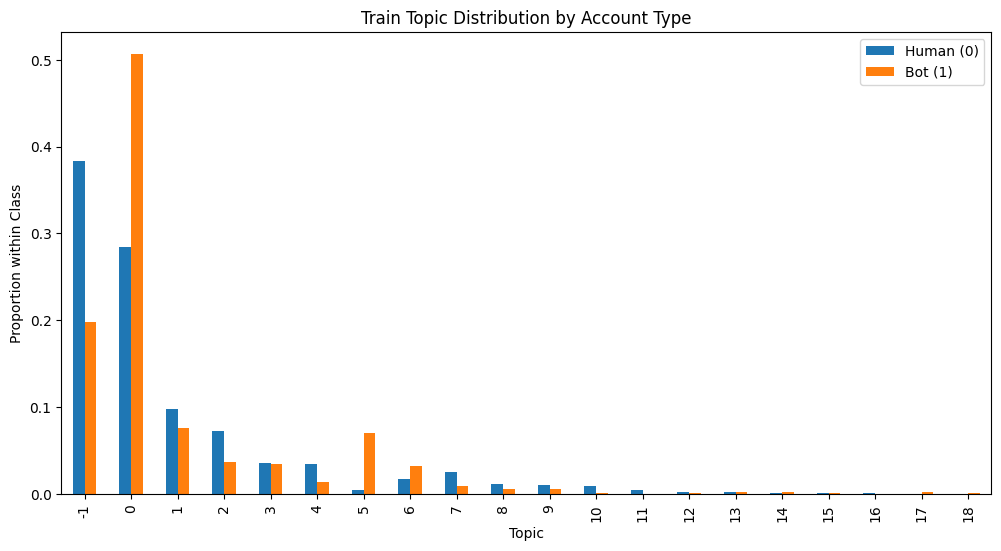


Top Topics:
   Topic  Count                                               Name  \
0     -1   9652                                -1_love_life_im_mom   
1      0  10722  0_missing_description_missing_description miss...   
2      1   2711                   1_translationtext_twitter_im_bot   
3      2   1822                     2_music_artist_writer_designer   
4      3   1061                             3_love_life_dream_live   
5      4    820                4_husband_father_husband father_dad   
6      5    784                              5_come_like_want_site   
7      6    661          6_trading_stock_day trading_trading stock   
8      7    597                  7_news_journalist_reporter_editor   
9      8    292                             8_coffee_dog_mom_lover   

                                      Representation  \
0  [love, life, im, mom, lover, world, fan, write...   
1  [missing_description, missing_description miss...   
2  [translationtext, twitter, im, bot, official,

In [89]:
# drop unused columns 
df_bert = df.drop(columns=['description', 'description_en_embeddings']).copy()

# check empty descriptions
empty_count = df_bert['description_en'].isna().sum()
print(f"Empty descriptions: {empty_count}")
print(f"Percentage of total: {empty_count / len(df) * 100:.2f}%")

# replace empty descriptions with placeholder
df_bert['description_en'] = df_bert['description_en'].fillna("missing_description")

# convert to binary
df_bert['account_type'] = df_bert['account_type'].map({'bot': 1, 'human': 0})

# train/test 80/20
train_df, test_df  = train_test_split(df_bert, test_size=0.2, stratify=df_bert['account_type'], random_state=42)

# tabular features
bool_cols = ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']
cat_cols  = ['lang', 'description_language']
num_cols  = [
    'favourites_count', 'followers_count', 'friends_count',
    'average_tweets_per_day', 'account_age_days', 'word_count',
    'mean_word_length', 'hashtag_count', 'handle_count',
    'url_count', 'log_followers_friends_ratio'
]

# booleans to int
for col in bool_cols:
    train_df[col] = train_df[col].astype(int)
    test_df[col]  = test_df[col].astype(int)

# one-hot encode categoricals
train_df = pd.get_dummies(train_df, columns=cat_cols, drop_first=False)
test_df  = pd.get_dummies(test_df, columns=cat_cols, drop_first=False)
test_df  = test_df.reindex(columns=train_df.columns, fill_value=0)

# scale numeric features
scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols]  = scaler.transform(test_df[num_cols])

# define BERTopic model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")  # English

umap_model = umap.UMAP(
    n_neighbors=15,
    n_components=10,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=10,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

vectorizer_model = CountVectorizer(ngram_range=(1,3), stop_words='english')

nr_topics = 20

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    language="english",
    nr_topics=nr_topics,
    top_n_words=10
)

# fit BERTopic model on train set 
train_texts = train_df['description_en'].tolist()
topics_train, probs_train = topic_model.fit_transform(train_texts)

# transform test set
test_texts  = test_df['description_en'].tolist()
topics_test, probs_test = topic_model.transform(test_texts)

# add topics to DataFrames
train_df['topic'] = topics_train
test_df['topic']  = topics_test

# visualise performance
topic_counts = train_df['topic'].value_counts(normalize=True).sort_index()
print("\nTrain Topic Proportions (%):")
print((topic_counts*100).round(2))

# topic proportions by account_type
topic_by_label = train_df.groupby(['account_type','topic']).size().unstack(fill_value=0)
topic_by_label = topic_by_label.div(topic_by_label.sum(axis=1), axis=0)
topic_by_label.T.plot(kind="bar", figsize=(12,6))
plt.title("Train Topic Distribution by Account Type")
plt.ylabel("Proportion within Class")
plt.xlabel("Topic")
plt.legend([f"{label} ({i})" for i, label in enumerate(["Human", "Bot"])])
plt.show()

# look at top topics
topic_info = topic_model.get_topic_info()
print("\nTop Topics:")
print(topic_info.head(10))

# example: topic 3 words
print("\nExample Topic 3 Words:")
print(topic_model.get_topic(3))

# create feature matrices 

# one-hot encode topics
topic_dummies_train = pd.get_dummies(train_df['topic'].astype(str), prefix='topic')
topic_dummies_test  = pd.get_dummies(test_df['topic'].astype(str), prefix='topic')

# align columns
topic_dummies_test = topic_dummies_test.reindex(columns=topic_dummies_train.columns, fill_value=0)

# tabular features
tabular_cols = [c for c in train_df.columns if c not in ['description_en', 'topic', 'account_type']]

X_train_bert = np.hstack([topic_dummies_train.values, train_df[tabular_cols].values])
X_test_bert  = np.hstack([topic_dummies_test.values, test_df[tabular_cols].values])

y_train_bert = train_df['account_type'].values
y_test_bert  = test_df['account_type'].values

print("X_train_bert shape:", X_train_bert.shape)
print("X_test_bert shape:", X_test_bert.shape)

In [90]:
# check topic distribution between train and test
topic_counts_train = train_df['topic'].value_counts(normalize=True).sort_index()
print("\nTrain Topic Proportions (%):")
print((topic_counts_train * 100).round(2))

topic_counts_test = test_df['topic'].value_counts(normalize=True).sort_index()
print("\nTest Topic Proportions (%):")
print((topic_counts_test * 100).round(2))


Train Topic Proportions (%):
-1     32.23
 0     35.80
 1      9.05
 2      6.08
 3      3.54
 4      2.74
 5      2.62
 6      2.21
 7      1.99
 8      0.97
 9      0.88
 10     0.64
 11     0.28
 12     0.22
 13     0.22
 14     0.17
 15     0.10
 16     0.10
 17     0.09
 18     0.05
Name: topic, dtype: float64

Test Topic Proportions (%):
-1     35.98
 0     35.07
 1      7.85
 2      6.09
 3      2.95
 4      2.32
 5      2.88
 6      1.86
 7      1.60
 8      0.80
 9      0.76
 10     0.79
 11     0.47
 12     0.15
 13     0.17
 14     0.08
 15     0.04
 16     0.04
 17     0.07
 18     0.03
Name: topic, dtype: float64


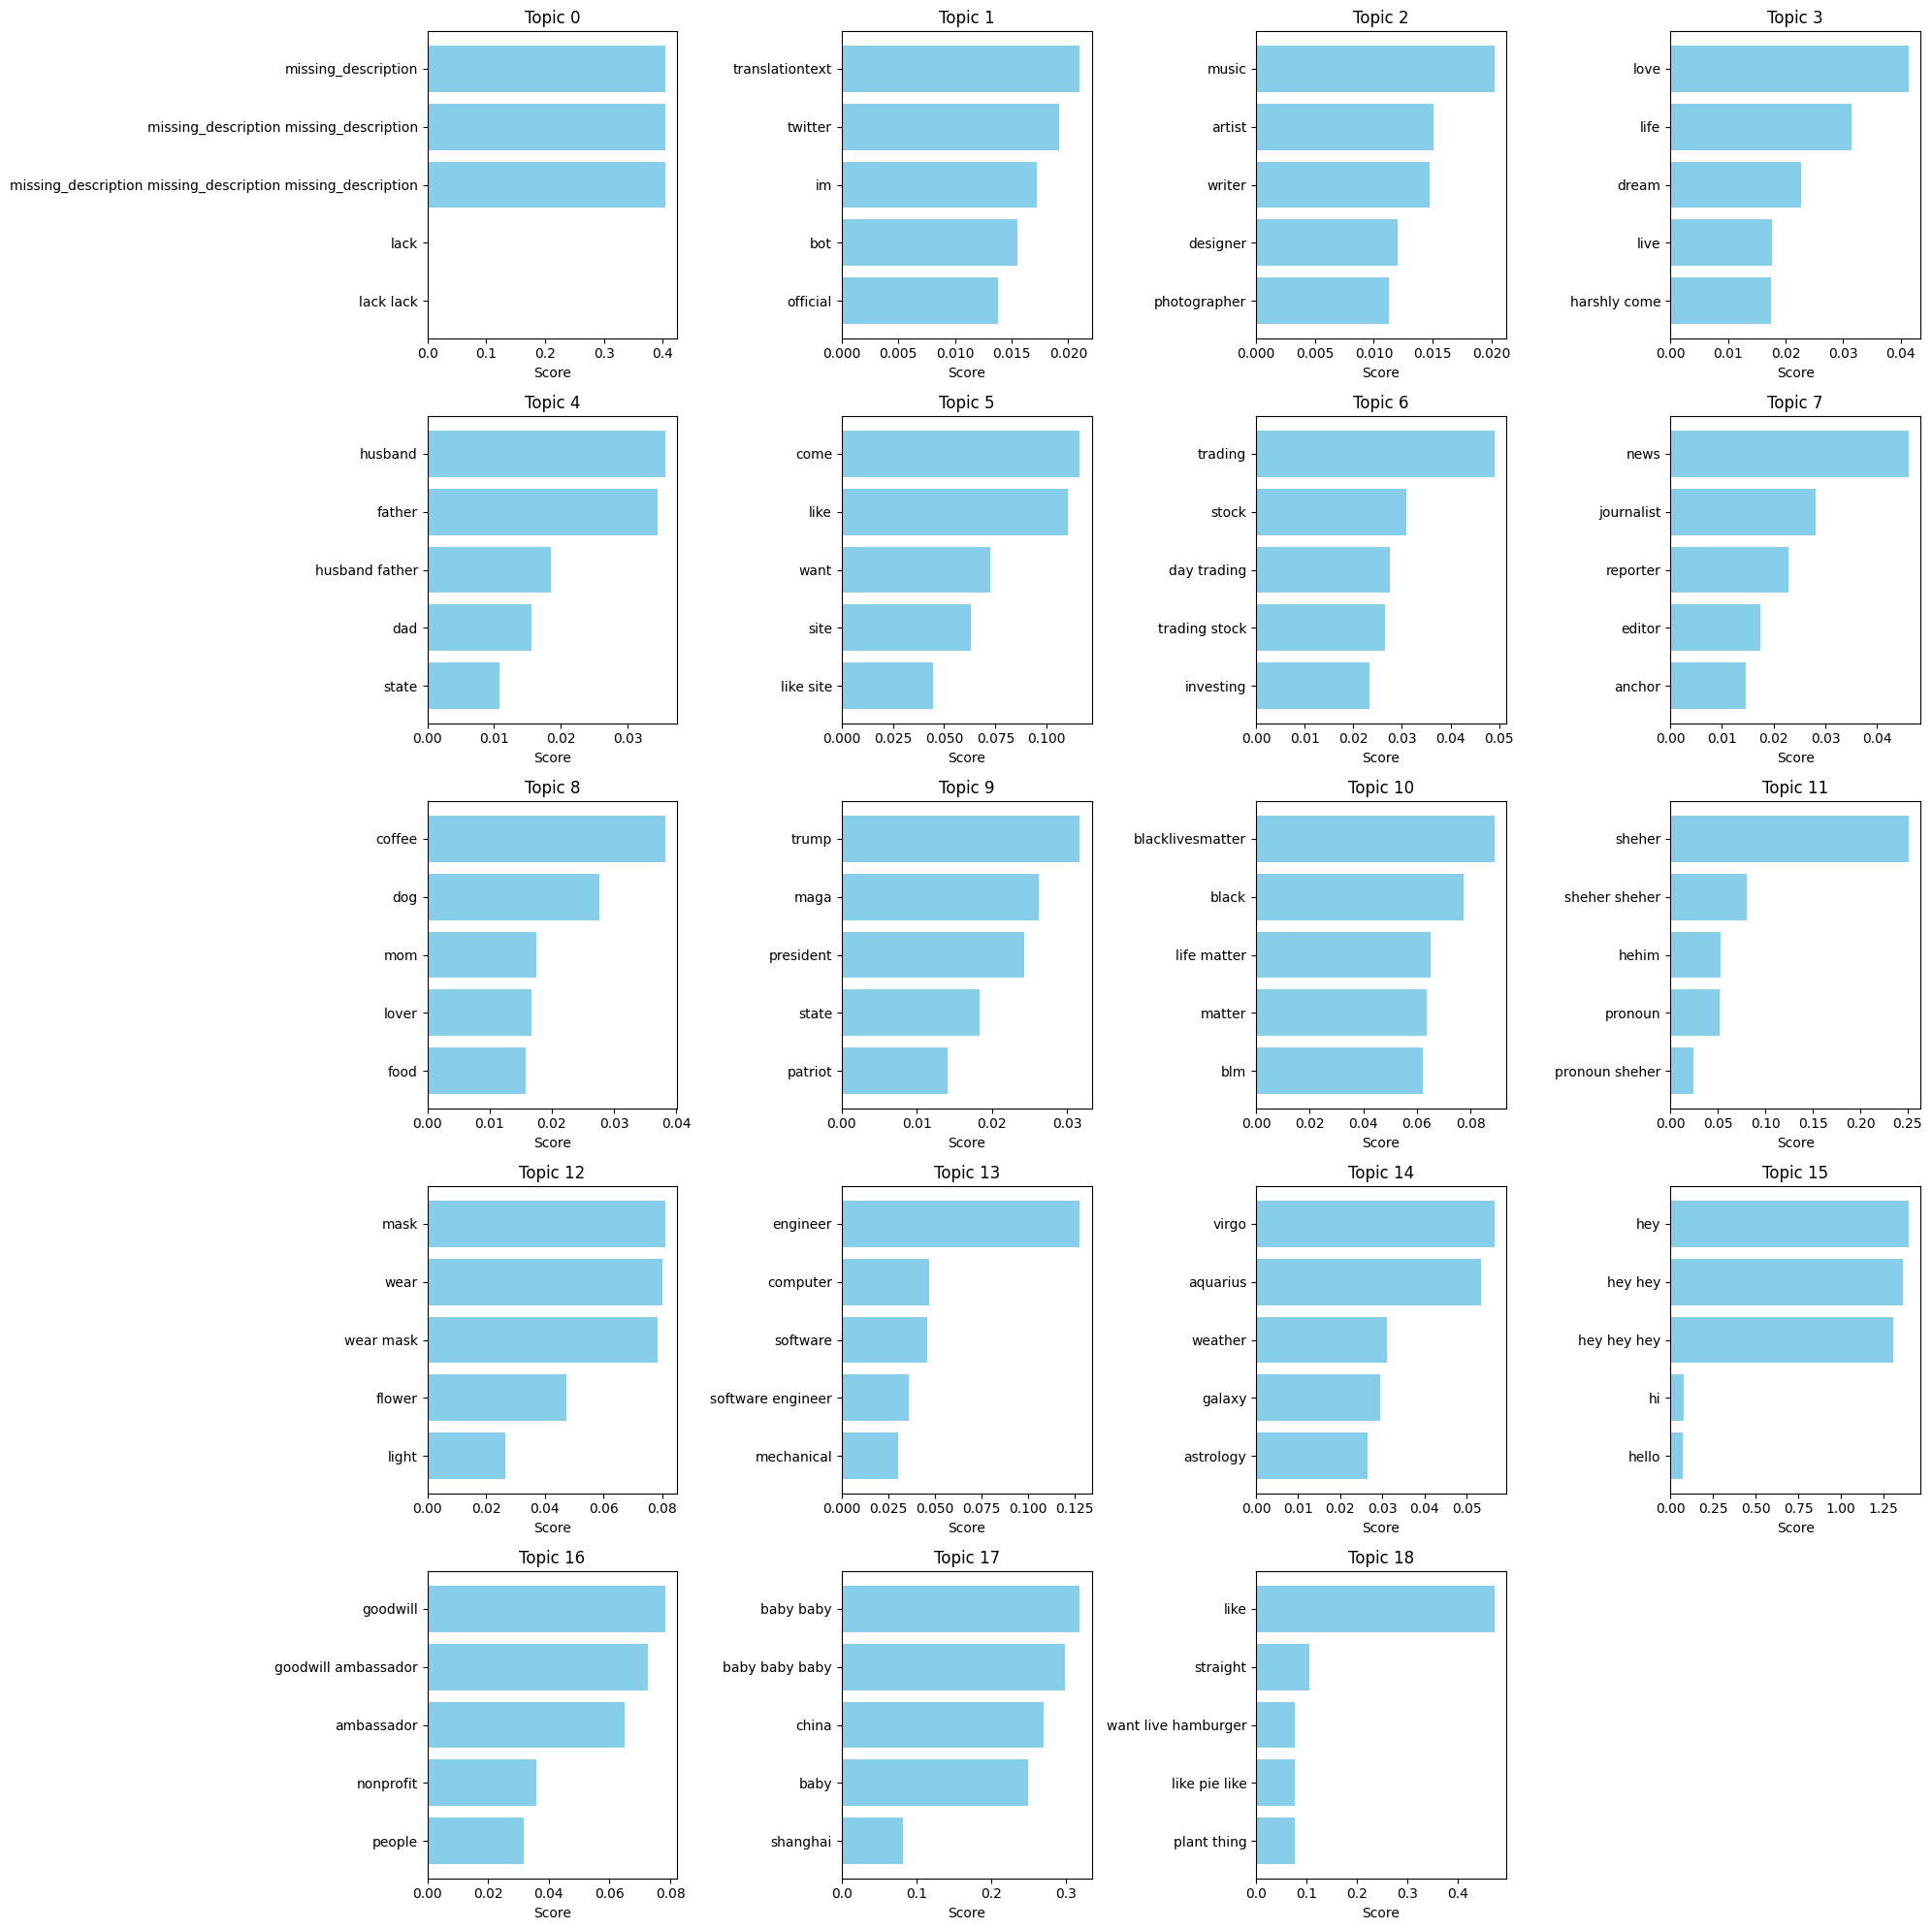

In [91]:
top_n_words = 5  # number of top words to show
topics = topic_model.get_topics()
topics_to_plot = [tid for tid in topics.keys() if tid != -1]  # skip -1

# grid size: 4 plots per row
n_cols = 4
n_rows = math.ceil(len(topics_to_plot) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()  # flatten in case of multiple rows

for i, topic_id in enumerate(topics_to_plot):
    words_scores = topics[topic_id][:top_n_words]
    words, scores = zip(*words_scores)
    axes[i].barh(words, scores, color='skyblue')
    axes[i].set_title(f"Topic {topic_id}")
    axes[i].invert_yaxis()  # highest score on top
    axes[i].set_xlabel("Score")

# hide any unused subplots if number of topics is not divisible by n_cols
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [92]:
# check if there is contamination in the test set
train_df = pd.DataFrame(X_train_bert)
test_df = pd.DataFrame(X_test_bert)

# find overlaps / intersection between train and test sets
contaminated_samples = train_df.merge(test_df, how='inner')

if contaminated_samples.shape[0] > 0:
    print(f"Warning: {contaminated_samples.shape[0]} duplicate samples found in both train and test sets.")
else:
    print("No contamination detected.")

No contamination detected.


In [93]:
# convert to DataFrames for comparison
train_check = pd.DataFrame(X_train_bert)
test_check = pd.DataFrame(X_test_bert)

# find overlapping rows
overlap = pd.merge(train_check, test_check, how='inner')

if len(overlap) > 0:
    print(f"{len(overlap)} overlapping samples found between train and test sets!")
else:
    print("No overlap detected between train and test sets.")

No overlap detected between train and test sets.


In [94]:
# initialise Logistic Regression
lr_bert = LogisticRegression(max_iter=1000, class_weight='balanced')

# cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# cross-validated predicted probabilities on train set
train_prob_cv = cross_val_predict(lr_bert, X_train_bert, y_train_bert, cv=cv, method='predict_proba')[:, 1]
y_train_pred_cv = (train_prob_cv >= 0.5).astype(int)

# evaluate on train CV
print("LR Train CV Accuracy:", accuracy_score(y_train_bert, y_train_pred_cv))
print("LR Train CV ROC-AUC:", roc_auc_score(y_train_bert, train_prob_cv))
print(classification_report(y_train_bert, y_train_pred_cv))

# fit model on full training set
lr_bert.fit(X_train_bert, y_train_bert)

LR Train CV Accuracy: 0.7524874791318865
LR Train CV ROC-AUC: 0.8434347715478276
              precision    recall  f1-score   support

           0       0.88      0.72      0.80     20010
           1       0.59      0.81      0.68      9940

    accuracy                           0.75     29950
   macro avg       0.74      0.77      0.74     29950
weighted avg       0.79      0.75      0.76     29950



,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [95]:
# predict on test set
y_test_pred = lr_bert.predict(X_test_bert)
y_test_prob = lr_bert.predict_proba(X_test_bert)[:, 1]

# evaluate on test set
print("LR Test Accuracy:", accuracy_score(y_test_bert, y_test_pred))
print("LR Test AUC:", roc_auc_score(y_test_bert, y_test_prob))
print(classification_report(y_test_bert, y_test_pred))

LR Test Accuracy: 0.750801282051282
LR Test AUC: 0.8439206898396174
              precision    recall  f1-score   support

           0       0.88      0.73      0.80      5003
           1       0.59      0.79      0.68      2485

    accuracy                           0.75      7488
   macro avg       0.73      0.76      0.74      7488
weighted avg       0.78      0.75      0.76      7488



Top features for Logistic Regression:
       feature  importance
26    verified    2.457176
15     topic_5    2.157635
60     lang_mk    1.917922
82  lang_zh-cn    1.835027
4     topic_11    1.789317
68     lang_ru    1.536320
3     topic_10    1.383047
53     lang_hu    1.324612
57     lang_ko    1.306912
10    topic_17    1.259861


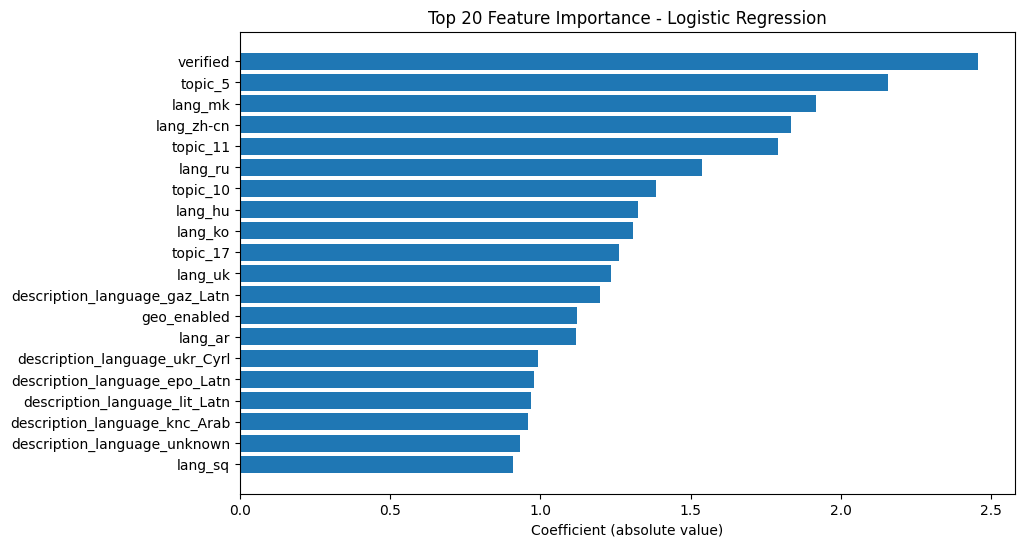

In [96]:
# feature names (topic + tabular)
feature_names = topic_dummies_train.columns.tolist() + tabular_cols

# coefficients
lr_coef = lr_bert.coef_[0]  # binary classification

# LR feature importance
lr_feat_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(lr_coef)
}).sort_values(by='importance', ascending=False)

print("Top features for Logistic Regression:")
print(lr_feat_importance.head(10))

# plot top 20 features
plt.figure(figsize=(10,6))
plt.barh(lr_feat_importance['feature'].head(20), lr_feat_importance['importance'].head(20))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importance - Logistic Regression")
plt.xlabel("Coefficient (absolute value)")
plt.show()

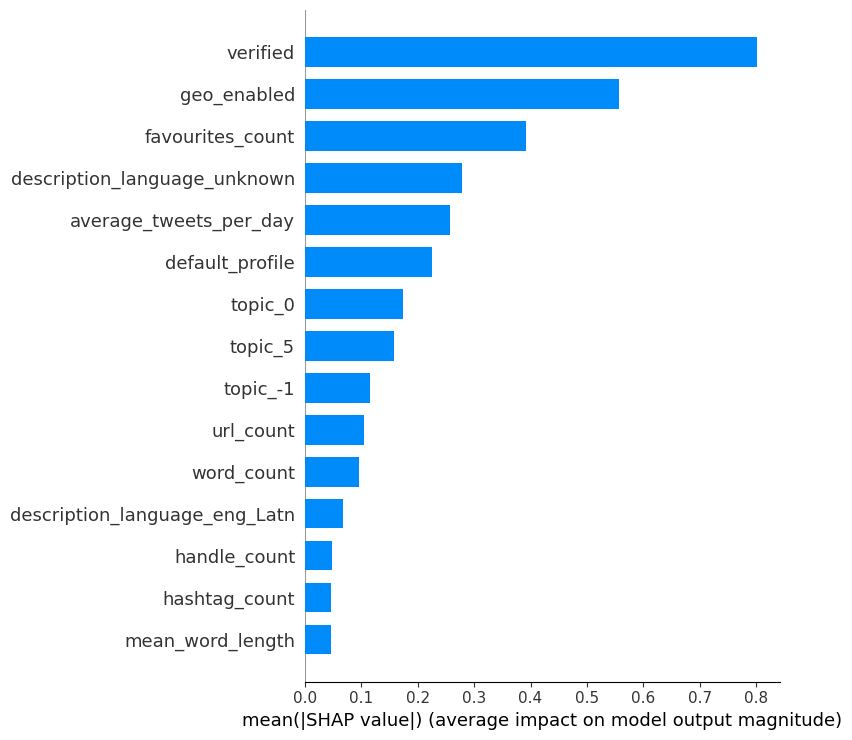

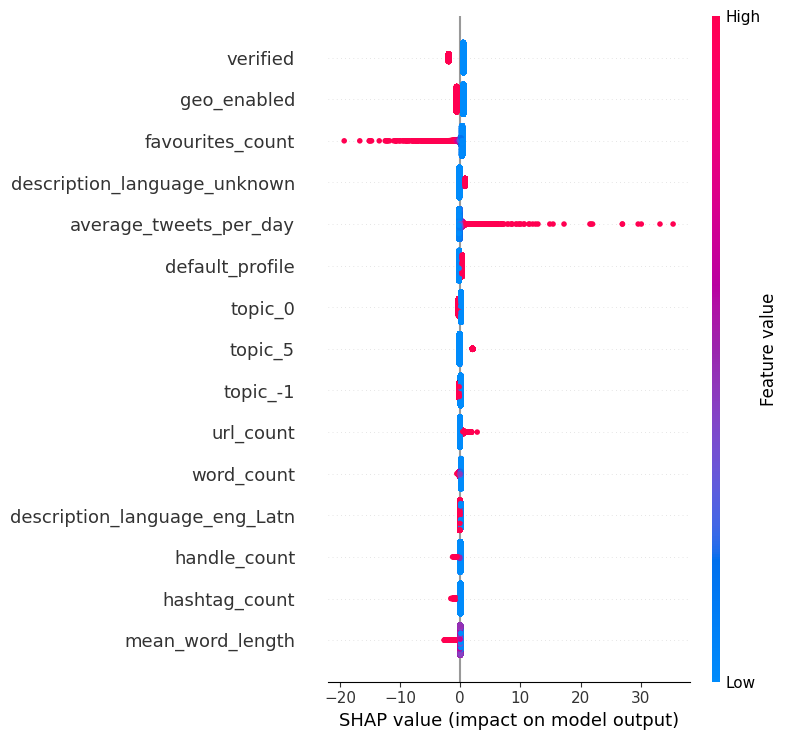

In [97]:
explainer_lr = shap.LinearExplainer(lr_bert, X_train_bert, feature_perturbation="interventional")
shap_values_lr = explainer_lr.shap_values(X_train_bert)

# Summary plot
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values_lr, X_train_bert, feature_names=feature_names, plot_type="bar", max_display=15)

plt.figure(figsize=(8,6))
shap.summary_plot(shap_values_lr, X_train_bert, feature_names=feature_names, max_display=15)

In [98]:
# initialise model
dt_bert = DecisionTreeClassifier(max_depth=None, class_weight='balanced', random_state=42)

# cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# cross-validated predicted probabilities on train set
train_prob_cv = cross_val_predict(dt_bert, X_train_bert, y_train_bert, cv=cv, method='predict_proba')[:, 1]
y_train_pred_cv = (train_prob_cv >= 0.5).astype(int)

# evaluate CV performance on train
print("DT Train CV Accuracy:", accuracy_score(y_train_bert, y_train_pred_cv))
print("DT Train CV ROC-AUC:", roc_auc_score(y_train_bert, train_prob_cv))
print(classification_report(y_train_bert, y_train_pred_cv))

# fit model on full training set
dt_bert.fit(X_train_bert, y_train_bert)


DT Train CV Accuracy: 0.822237061769616
DT Train CV ROC-AUC: 0.7999595524169505
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     20010
           1       0.73      0.73      0.73      9940

    accuracy                           0.82     29950
   macro avg       0.80      0.80      0.80     29950
weighted avg       0.82      0.82      0.82     29950



,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [99]:
# predict on test set
y_test_pred = dt_bert.predict(X_test_bert)
y_test_prob = dt_bert.predict_proba(X_test_bert)[:, 1]

# evaluate test set performance
print("DT Test Accuracy:", accuracy_score(y_test_bert, y_test_pred))
print("DT Test ROC-AUC:", roc_auc_score(y_test_bert, y_test_prob))
print(classification_report(y_test_bert, y_test_pred))

DT Test Accuracy: 0.828926282051282
DT Test ROC-AUC: 0.8069632667079832
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      5003
           1       0.74      0.74      0.74      2485

    accuracy                           0.83      7488
   macro avg       0.81      0.81      0.81      7488
weighted avg       0.83      0.83      0.83      7488



Top features for Decision Tree:
                        feature  importance
23              followers_count    0.336761
22             favourites_count    0.125401
27       average_tweets_per_day    0.106073
28             account_age_days    0.099520
24                friends_count    0.096200
34  log_followers_friends_ratio    0.047180
30             mean_word_length    0.030730
29                   word_count    0.024534
26                     verified    0.023266
25                  geo_enabled    0.012783


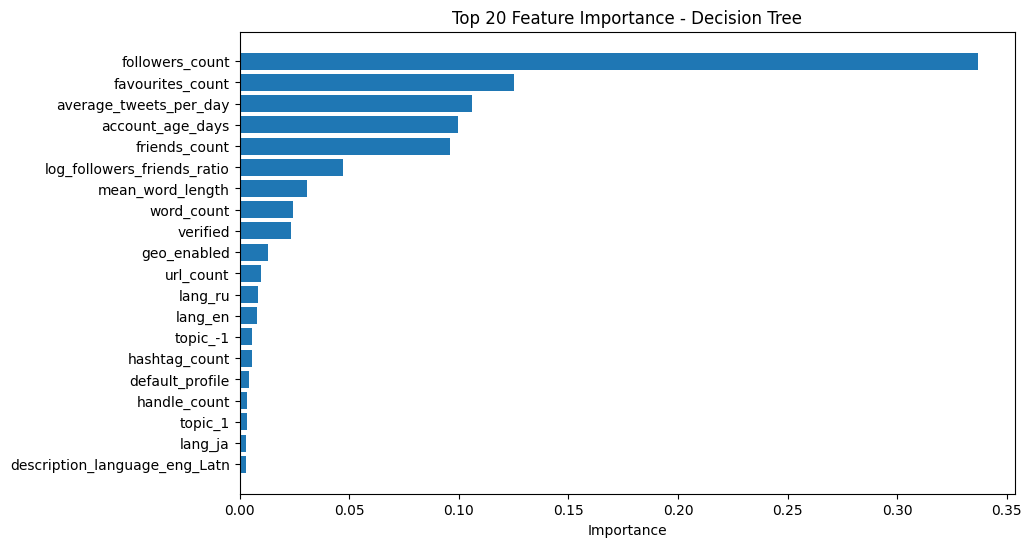

In [100]:
# feature importance
dt_feat_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': dt_bert.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Top features for Decision Tree:")
print(dt_feat_importance.head(10))

# plot top 20 features
plt.figure(figsize=(10,6))
plt.barh(dt_feat_importance['feature'].head(20), dt_feat_importance['importance'].head(20))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importance - Decision Tree")
plt.xlabel("Importance")
plt.show()

In [101]:
X_train_df = pd.DataFrame(X_train_bert, columns=feature_names)

explainer_dt = shap.TreeExplainer(dt_bert)
shap_values_dt = explainer_dt.shap_values(X_train_df)

print(type(shap_values_dt))
if isinstance(shap_values_dt, list):
    print([s.shape for s in shap_values_dt])
else:
    print(shap_values_dt.shape)
print("X_train_df shape:", X_train_df.shape)

<class 'numpy.ndarray'>
(29950, 212, 2)
X_train_df shape: (29950, 212)


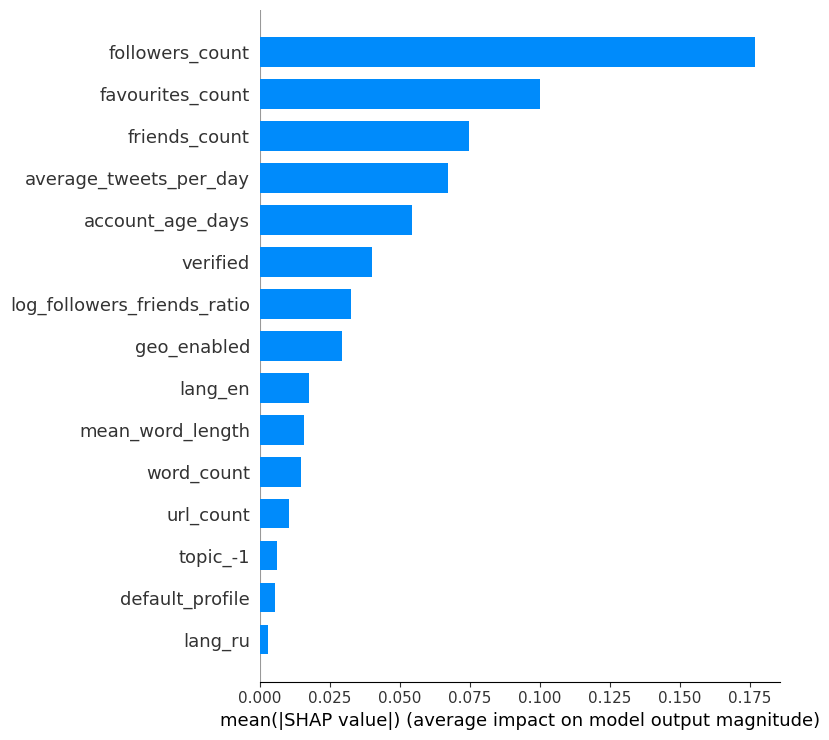

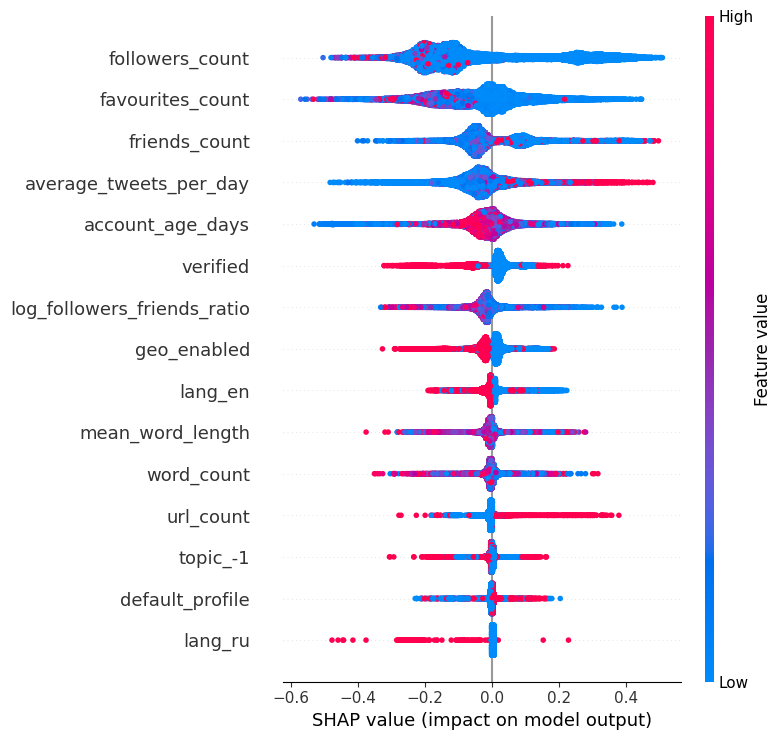

In [102]:
shap_values_class1 = shap_values_dt[:, :, 1]

# Bar summary plot
shap.summary_plot(shap_values_class1, X_train_df, plot_type="bar", max_display=15)
shap.summary_plot(shap_values_class1, X_train_df, max_display=15)

In [103]:
# initialise RF model
rf_bert = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)

# cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# cross-validated predicted probabilities on train set
train_prob_cv = cross_val_predict(
    rf_bert,
    X_train_bert,
    y_train_bert,
    cv=cv,
    method='predict_proba'
)[:, 1]

y_train_pred_cv = (train_prob_cv >= 0.5).astype(int)

# evaluate CV performance on train
print("RF Train CV Accuracy:", accuracy_score(y_train_bert, y_train_pred_cv))
print("RF Train CV ROC-AUC:", roc_auc_score(y_train_bert, train_prob_cv))
print(classification_report(y_train_bert, y_train_pred_cv))

# fit model on full training set
rf_bert.fit(X_train_bert, y_train_bert)

RF Train CV Accuracy: 0.8698831385642738
RF Train CV ROC-AUC: 0.9284731728703053
              precision    recall  f1-score   support

           0       0.87      0.94      0.91     20010
           1       0.86      0.72      0.79      9940

    accuracy                           0.87     29950
   macro avg       0.87      0.83      0.85     29950
weighted avg       0.87      0.87      0.87     29950



,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [104]:
# predict on test set
y_test_pred = rf_bert.predict(X_test_bert)
y_test_prob = rf_bert.predict_proba(X_test_bert)[:, 1]

# evaluate test set
print("RF Test Accuracy:", accuracy_score(y_test_bert, y_test_pred))
print("RF Test ROC-AUC:", roc_auc_score(y_test_bert, y_test_prob))
print(classification_report(y_test_bert, y_test_pred))

RF Test Accuracy: 0.8699252136752137
RF Test ROC-AUC: 0.9297839002835724
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      5003
           1       0.86      0.72      0.79      2485

    accuracy                           0.87      7488
   macro avg       0.87      0.83      0.85      7488
weighted avg       0.87      0.87      0.87      7488



Top features for Random Forest:
                        feature  importance
23              followers_count    0.149634
22             favourites_count    0.133771
24                friends_count    0.119128
27       average_tweets_per_day    0.099845
28             account_age_days    0.082269
34  log_followers_friends_ratio    0.081785
30             mean_word_length    0.048938
25                  geo_enabled    0.038308
29                   word_count    0.037848
26                     verified    0.033804


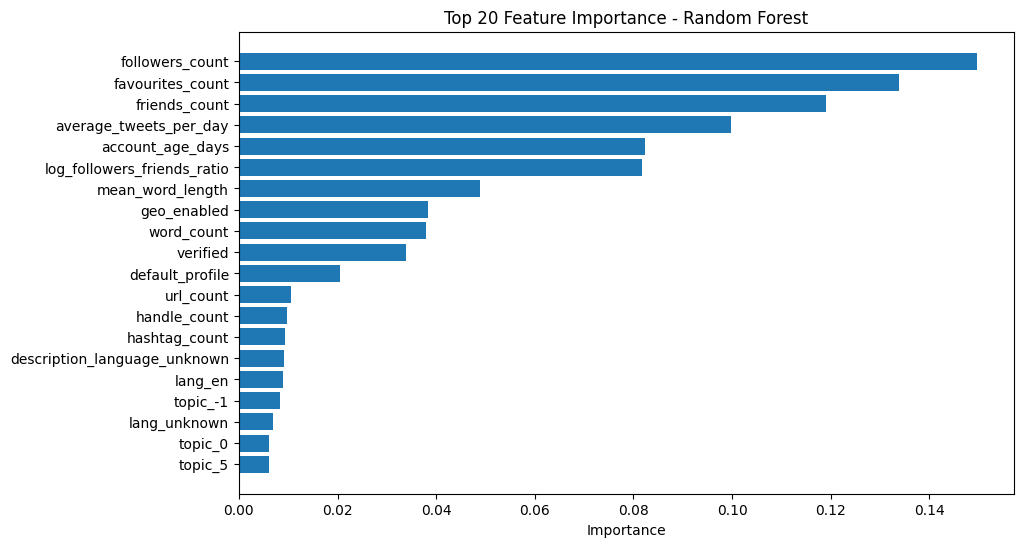

In [105]:
# RF feature importance
rf_feat_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_bert.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Top features for Random Forest:")
print(rf_feat_importance.head(10))

# plot top 20 features
plt.figure(figsize=(10,6))
plt.barh(rf_feat_importance['feature'].head(20), rf_feat_importance['importance'].head(20))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.show()

In [106]:
# X_train_df = pd.DataFrame(X_train_bert, columns=feature_names)

# explainer_rf = shap.TreeExplainer(rf_bert)
# shap_values_rf = explainer_rf.shap_values(X_train_df)

# print(type(shap_values_rf))
# print(np.array(shap_values_rf).shape)

# shap_values_rf_class1 = shap_values_rf[:, :, 1]

# shap.summary_plot(shap_values_rf_class1, X_train_df, plot_type="bar", max_display=15)
# shap.summary_plot(shap_values_rf_class1, X_train_df, max_display=15)